In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
from collections import namedtuple
from jax import random, grad, jit, lax, vmap
import jax.numpy as jnp
import jax
import numpy as np
from jax.scipy.stats import multivariate_normal
from jax.scipy.stats import t as studentst
import seaborn as sns
import scipy
import sys
import os
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd

from model_functions import *

## Plot energy landscape

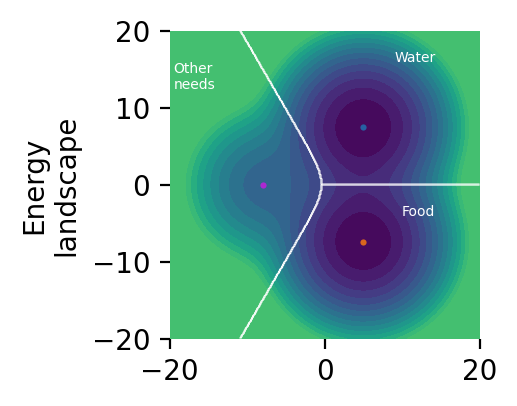

In [13]:
# Plot the energy landscape defined by model_functions.f

# Change thirst and hunger magnitudes here to reshape the wells
thirst = 3.0
hunger = 3.0
g = 3. # gradient scale
w = 6. # relative foraging scale

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
col = dict(zip(["water","food","miss"], [sns.color_palette()[i] for i in [0,1,2]]))


# Make colormap
cmap = plt.get_cmap('viridis')
cut_viridis_2 = truncate_colormap(cmap, 0.0, .7, 500)
# Set range of XY to plot
minval = -20
maxval = 20
sample_density = 300
X,Y = jnp.meshgrid(jnp.linspace(minval,maxval,sample_density), jnp.linspace(minval,maxval,sample_density))
points = jnp.vstack([X.flatten(), Y.flatten()]).T

# Evaluate landscape over points
fpar = jnp.array([1., 1., g, w])
data0 = f(points, t=thirst, h=hunger, params=fpar).reshape((sample_density,sample_density))
# Min and max values for colorbar
dmin = data0.min()
dmax = f(other_mean+jnp.array([-10.,0]), t=thirst, h=hunger, params=fpar)

# Plotting code
plt.figure(figsize=(2,2), dpi=200)
ax = plt.subplot(111)
# Plot the landscape
cs = ax.contourf(f(points, t=thirst, h=hunger, params=fpar).reshape((sample_density,sample_density)),
                 extent=[minval, maxval, minval, maxval],
                 levels=np.linspace(dmin, dmax, 15),
                 vmin=dmin,
                 vmax=dmax,
                 cmap=cut_viridis_2,
                 extend='max')
# Add lines dividing the landscape zones
cs = ax.contour(food_choice(points).reshape((sample_density,sample_density)), levels=[0], extent=[minval, maxval, minval, maxval], colors='white', linestyles='solid', linewidths=0.4, antialiased=True)
cs = ax.contour(miss(points).reshape((sample_density,sample_density)), levels=[0], extent=[minval, maxval, minval, maxval], colors='white', linestyles='solid', linewidths=0.4, antialiased=True)
cs = ax.contour(water_choice(points).reshape((sample_density,sample_density)), levels=[0], extent=[minval, maxval, minval, maxval], colors='white', linestyles='solid', linewidths=0.4, antialiased=True)
ax.scatter(hunger_mean[0], hunger_mean[1], s=5, color=col['food'], alpha=0.8, linewidth=0)
# Add center points for wells
ax.scatter(thirst_mean[0], thirst_mean[1], s=5, color=col['water'], alpha=0.8, linewidth=0)
ax.scatter(other_mean[0], other_mean[1], s=5, color='magenta', alpha=0.6, linewidth=0)
# Label the plot
ax.set_ylabel("Energy\nlandscape")
ax.text(-19.5,12.5, "Other\nneeds", fontsize=5, color='white')
ax.text(10,-4, "Food", fontsize=5, color='white')
ax.text(9,16, "Water", fontsize=5, color='white')
ax.set_frame_on(False)

## Run a simulated behavioral session

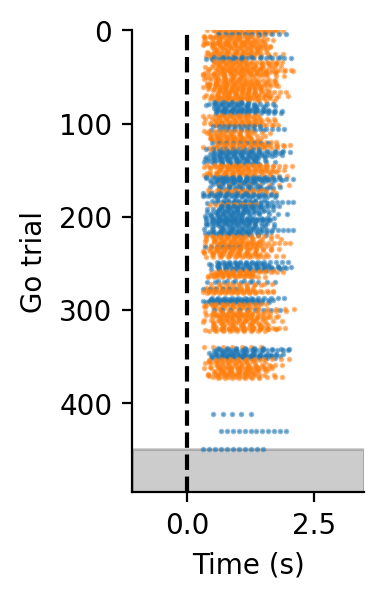

In [14]:
# Set random key for different simulations
key = 0

# Set length of simulation
nsamples = int(1.75*60*60/dt)
# Get random keys
all_keys, all_go_array = get_random_series(key, nsamples, 1)

params = jnp.array([1.,2.5563507,6.4874935,2.807799])

p = {
    'gradient_weight': params[0],
    'well_scale': params[3],
    'noise_weight': jnp.sqrt(params[1]*params[0]),
    'needs_weight': params[2],
    'water_feedback_constant': water_feedback_constant,
    'food_feedback_constant': food_feedback_constant,
}

# Run simulation
final_state = run_simulation_(all_keys[0], all_go_array[0], p, .85, .85)
# Plot it
plot_simulated_behavior(final_state, dpi=200)

## Generate a session and visualize activity from one state to another

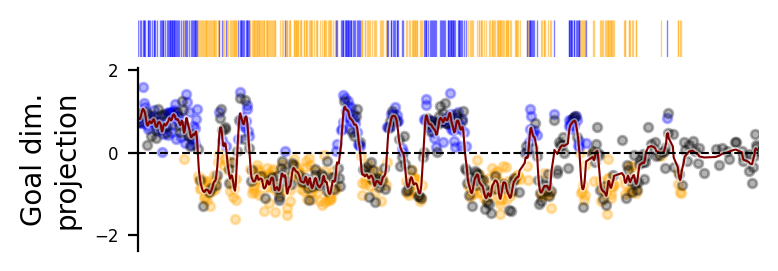

In [23]:
# Random key for session
key = 1

# Set simulation parameters
nsamples = int(2.*60*60/dt)
all_keys, all_go_array = get_random_series(key, nsamples, 1)

params = jnp.array([1.,2.5563507,6.4874935,2.807799])

p = {
    'gradient_weight': params[0],
    'well_scale': params[3],
    'noise_weight': jnp.sqrt(params[1]*params[0]),
    'needs_weight': params[2],
    'water_feedback_constant': water_feedback_constant,
    'food_feedback_constant': food_feedback_constant,
}
# Run simulation
final_state = run_simulation_(all_keys[0], all_go_array[0], p, 1., 1.)
posterior_samples = np.array(final_state.all_u)


# Project to separating axis
goal_cd = (thirst_mean-hunger_mean)
goal_cd = goal_cd/np.linalg.norm(goal_cd)
goal_proj = np.dot(goal_cd,posterior_samples.T)

# Process trial outcomes
t = final_state.choice[final_state.go>0,:]
trial_encoding = []
temp = np.array(t).copy()
temp[:,1] = temp[:,1]*1
temp[:,2] = temp[:,2]*2
temp[:,3] = temp[:,3]*3
temp[:,0] = -1*((temp[:,0]==0)&(temp[:,3]==0))
temp[temp[:,0]==-1,0] = 4
temp = temp.sum(1)-1
trial_encoding.append(temp)
trial_encoding = np.array(trial_encoding[0])

# Set up figure
fig = plt.figure(figsize=(4,1.5), dpi=200)
gs = plt.GridSpec(ncols=1,nrows=2,height_ratios=[.2, 1], hspace=0.1)

# Plot choices over session
ax = plt.subplot(gs[0])
trial_idx = jnp.where(final_state.go!=0)[0]
idxes = np.cumsum((final_state.choice[trial_idx,1:4]==1).sum(1))
ax.vlines(trial_idx[final_state.choice[trial_idx,1]==1], np.zeros(np.sum(final_state.choice[trial_idx,1]==1)), np.ones(np.sum(final_state.choice[trial_idx,1]==1)), color='orange', alpha=.5, linewidth=0.5)
ax.vlines(trial_idx[final_state.choice[trial_idx,2]==1], np.zeros(np.sum(final_state.choice[trial_idx,2]==1)), np.ones(np.sum(final_state.choice[trial_idx,2]==1)), color='blue', alpha=.5, linewidth=0.5)
ax.vlines(trial_idx[final_state.choice[trial_idx,3]==1], np.zeros(np.sum(final_state.choice[trial_idx,3]==1)), np.ones(np.sum(final_state.choice[trial_idx,3]==1)), color='white', alpha=0, linewidth=1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.axis('off')
sns.despine(left=True, bottom=True)
plt.margins(0)

# Plot goal activity over session
ax = plt.subplot(gs[1])
data0 = f(points, t=final_state.need[0,0], h=final_state.need[0,1], params=params).reshape((sample_density,sample_density))
dmax = data0.max()
dmin = data0.min()
gproj = goal_proj/np.percentile(goal_proj,95)
ax.scatter(trial_idx[final_state.choice[trial_idx,1]==1], gproj[trial_idx[final_state.choice[trial_idx,1]==1]], marker='o', alpha=0.3, facecolors='orange', s=10, rasterized=True)
ax.scatter(trial_idx[final_state.choice[trial_idx,2]==1], gproj[trial_idx[final_state.choice[trial_idx,2]==1]], marker='o', alpha=0.3, facecolors='blue', s=10, rasterized=True)
ax.scatter(trial_idx[final_state.choice[trial_idx,3]==1], gproj[trial_idx[final_state.choice[trial_idx,3]==1]], marker='o', alpha=0.3, facecolors='k', s=10, rasterized=True)

# Plot a smoothed version of the goal projection
all_idx = jnp.sort(jnp.hstack([trial_idx[final_state.choice[trial_idx,1]==1],
                      trial_idx[final_state.choice[trial_idx,2]==1],
                      trial_idx[final_state.choice[trial_idx,3]==1]]))
from scipy.signal import sosfiltfilt, butter
sos = butter(1, .2, output='sos')
ax.plot(all_idx, sosfiltfilt(sos, gproj[np.array(all_idx)]), color='white', alpha=0.5, linewidth=2)
ax.plot(all_idx, sosfiltfilt(sos, gproj[np.array(all_idx)]), color='maroon', alpha=1, linewidth=0.75)


# Clean and format plot
sns.despine(bottom=True)
plt.xticks([], [])
ax.spines['bottom'].set_visible(False)
plt.yticks(fontsize=6)
plt.ylabel("Goal dim.\nprojection")
ax.yaxis.labelpad = 5
ax.margins(0)
plt.axhline(0, linestyle='--', color='k', linewidth=0.75)
ax.set_ylim([gproj[all_idx].mean()-3*gproj[all_idx].std(),gproj[all_idx].mean()+3*gproj[all_idx].std()]);


## Example theoretical probabilities

In [37]:
thirst = 1.5
hunger = 0.2
time = 15. # seconds

params = jnp.array([1.,2.5563507,6.4874935,2.807799])

p_stay_water = Pww(thirst,hunger,time,params)
p_stay_food = Pff(thirst,hunger,time,params)

print(f"Probability of staying in water state: {p_stay_water}")
print(f"Probability of staying in food state: {p_stay_food}")

Probability of staying in water state: 0.9829679727554321
Probability of staying in food state: 0.8490639328956604


## Example fitting code

In [ ]:
# training_array should be a 2D numpy array of ['prev_reward', 'curr_reward', 'thirst', 'hunger', 'elapsed_time'] per trial
# marginal_array should be a 2D numpy array of ['outcome', 'thirst', 'hunger'] per trial

start_learning_rate = 1e-1
optimizer = optax.apply_if_finite(optax.adabelief(start_learning_rate),1)

all_params = jnp.array([1.       , 2.  , 2., 2.])

opt_state = optimizer.init(all_params)
losses = []
all_grads = []

n_steps = 5
n_reps = 50
for j in range(n_reps):
    for i in range(n_steps):
        mbatch = marginal_array[int(i*marginal_array.shape[0]/n_steps):
                                int((i+1)*marginal_array.shape[0]/n_steps)]
        tbatch = training_array
        loss_value, grads = jax.value_and_grad(loss_joint)(all_params,
                                                           tbatch,
                                                           mbatch)
        losses.append(loss_value)
        all_grads.append(grads)
        if i % 1 == 0:
            print(f"iter: {j}, loss: {loss_value}")
            print(f"params: {all_params}")
        updates, opt_state = optimizer.update(grads, opt_state)
        all_params = optax.apply_updates(all_params, updates)
